In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d crowww/a-large-scale-fish-dataset
import zipfile
zip_ref = zipfile.ZipFile('a-large-scale-fish-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
import matplotlib.image as mpimg

DIR = '/content/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(DIR) if '.' not in i]

label = []
path = []
for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            file_path = os.path.join(dirname, filename)
            class_name = dirname.split('/')[-1]
            if 'GT' not in class_name:
                path.append(file_path)
                label.append(class_name)

data_df = pd.DataFrame({'filepath': path, 'label': label})

def plot_species_images(dataframe, classes, num_images_per_class=5):
    plt.figure(figsize=(20, 20))

    for idx, species in enumerate(classes):
        species_images = dataframe[dataframe['label'] == species]['filepath'].values
        selected_images = random.sample(list(species_images), min(num_images_per_class, len(species_images)))

        for i, img_path in enumerate(selected_images):
            plt.subplot(len(classes), num_images_per_class, idx * num_images_per_class + i + 1)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.title(species)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot images
plot_species_images(data_df, classes)


Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.24G/3.24G [02:52<00:00, 19.5MB/s]
100% 3.24G/3.24G [02:52<00:00, 20.2MB/s]


In [2]:
# Split the data into train (70%), validation (15%), and test (15%) sets
train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 6300
Validation set size: 1350
Test set size: 1350


In [3]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

def create_model(learning_rate, num_dense_neurons):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_dense_neurons, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

Found 6300 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.


In [4]:
import numpy as np

class WOA:
    def __init__(self, obj_func, lb, ub, dim, num_agents, max_iter):
        self.obj_func = obj_func
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.dim = dim
        self.num_agents = num_agents
        self.max_iter = max_iter

    def optimize(self):
        whales = np.random.uniform(0, 1, (self.num_agents, self.dim)) * (self.ub - self.lb) + self.lb
        leader_whale = np.zeros(self.dim)
        leader_score = float("inf")

        for t in range(self.max_iter):
            for i in range(self.num_agents):
                fitness = self.obj_func(whales[i, :])
                if fitness < leader_score:
                    leader_score = fitness
                    leader_whale = whales[i, :].copy()

            a = 2 - t * (2 / self.max_iter)
#Position Update
            for i in range(self.num_agents):
                r1 = np.random.random()
                r2 = np.random.random()
                A = 2 * a * r1 - a
                C = 2 * r2

                b = 1
                l = (a - 1) * np.random.random() + 1
                p = np.random.random()
#Shrinking Encircling and Spiral Updating Mechanism
                if p < 0.5:
                    if abs(A) < 1:
                        D = abs(C * leader_whale - whales[i, :])
                        whales[i, :] = leader_whale - A * D
                    else:
                        rand_idx = np.random.randint(0, self.num_agents)
                        X_rand = whales[rand_idx, :]
                        D = abs(C * X_rand - whales[i, :])
                        whales[i, :] = X_rand - A * D
                else:
                    D_prime = abs(leader_whale - whales[i, :])
                    whales[i, :] = D_prime * np.exp(b * l) * np.cos(2 * np.pi * l) + leader_whale

                whales[i, :] = np.clip(whales[i, :], self.lb, self.ub)

        return leader_whale, leader_score

In [5]:
def train_and_evaluate_model(params):
    learning_rate, batch_size, num_dense_neurons = params
    batch_size = int(batch_size)
    num_dense_neurons = int(num_dense_neurons)

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )

    model = create_model(learning_rate, num_dense_neurons)

    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator)
    )

    val_loss = history.history['val_loss'][-1]
    return val_loss

def objective_function(params):
    return train_and_evaluate_model(params)

In [6]:
# WOA hyperparameters
num_agents = 3
max_iter = 2
dim = 3

# Hyperparameter bounds
lb = [1e-5, 16, 32]
ub = [1e-2, 128, 512]

# Optimize using WOA
woa = WOA(objective_function, lb, ub, dim, num_agents, max_iter)
best_params, best_score = woa.optimize()

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_score)


Found 6300 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/5
55/55 [==============================] - 181s 3s/step - loss: 0.7283 - accuracy: 0.7576 - val_loss: 0.0997 - val_accuracy: 0.9844
Epoch 2/5
55/55 [==============================] - 147s 3s/step - loss: 0.1850 - accuracy: 0.9446 - val_loss: 0.0454 - val_accuracy: 0.9948
Epoch 3/5
55/55 [==============================] - 146s 3s/step - loss: 0.1136 - accuracy: 0.9644 - val_loss: 0.0287 - val_accuracy: 0.9941
Epoch 4/5
55/55 [==============================] - 147s 3s/step - loss: 0.1002 - accuracy: 0.9675 - val_loss: 0.0165 - val_accuracy: 0.9978
Epoch 5/5
55/55 [==============================] - 154s 3s/step - loss: 0.0600 - accuracy: 0.9833 - val_loss: 0.0145 - val_accuracy: 0.9985
Found 6300 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 

In [7]:
# Extract the best hyperparameters found by WOA
best_learning_rate, best_batch_size, best_num_dense_neurons = best_params
best_batch_size = int(best_batch_size)
best_num_dense_neurons = int(best_num_dense_neurons)

# Create the final model with the best hyperparameters
final_model = create_model(best_learning_rate, best_num_dense_neurons)

In [8]:
# Data generators with the best batch size
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=best_batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=best_batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=best_batch_size,
    class_mode='categorical',
    shuffle=False
)

# Train the final model
history = final_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Found 6300 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Epoch 1/5
55/55 [==============================] - 154s 3s/step - loss: 0.8190 - accuracy: 0.7346 - val_loss: 0.1065 - val_accuracy: 0.9815
Epoch 2/5
55/55 [==============================] - 147s 3s/step - loss: 0.2067 - accuracy: 0.9379 - val_loss: 0.0465 - val_accuracy: 0.9926
Epoch 3/5
55/55 [==============================] - 147s 3s/step - loss: 0.1308 - accuracy: 0.9590 - val_loss: 0.0299 - val_accuracy: 0.9948
Epoch 4/5
55/55 [==============================] - 150s 3s/step - loss: 0.0892 - accuracy: 0.9716 - val_loss: 0.0237 - val_accuracy: 0.9985
Epoch 5/5
55/55 [==============================] - 146s 3s/step - loss: 0.0725 - accuracy: 0.9783 - val_loss: 0.0128 - val_accuracy: 0.9993


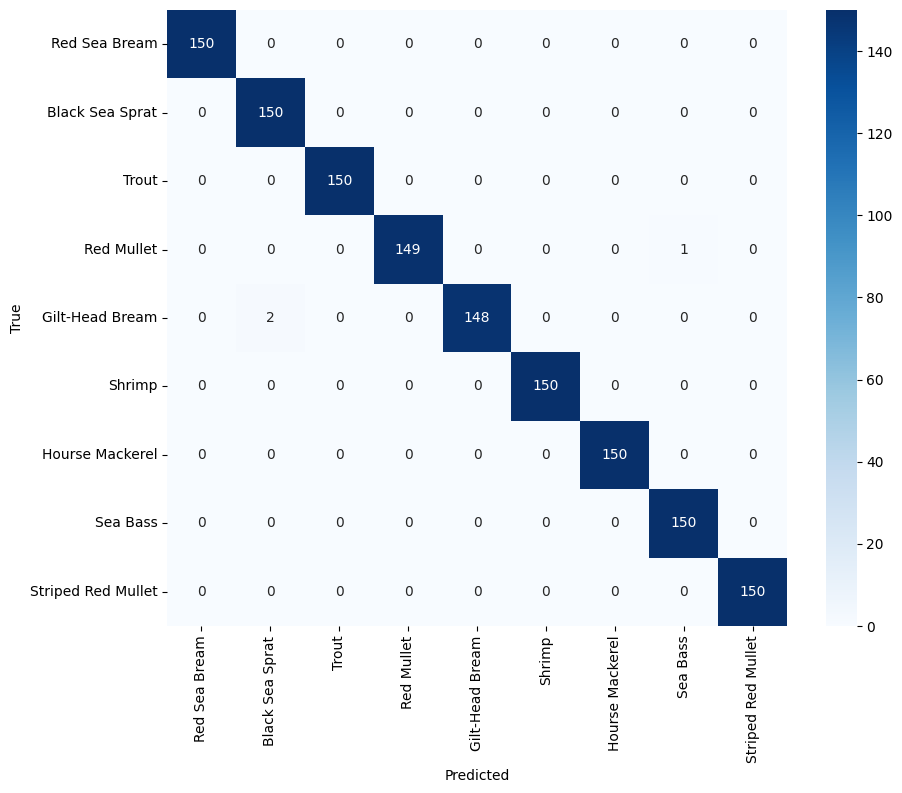

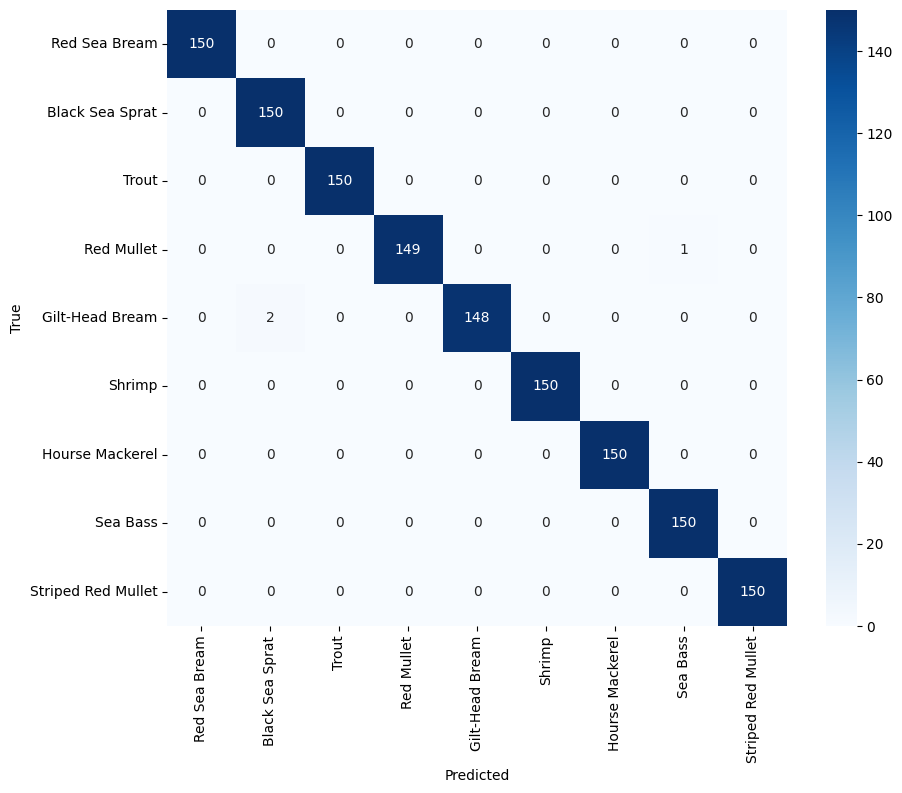

In [11]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate the model on the test data
test_loss, test_accuracy = final_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Get the true labels and predicted labels
y_true = test_df['label'].values
test_generator.reset()  # Ensure the generator starts from the beginning
y_pred_probs = final_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_pred_labels = [list(test_generator.class_indices.keys())[i] for i in y_pred]

# Classification report
report = classification_report(y_true, y_pred_labels, target_names=classes)
print("Classification Report:")
print(report)

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred_labels)
print(f"Overall Accuracy: {accuracy}")


12/12 [==============================] - 15s 1s/step - loss: 0.0141 - accuracy: 0.9978
Test Loss: 0.014105351641774178
Test Accuracy: 0.9977777600288391
12/12 [==============================] - 15s 1s/step
Classification Report:
                    precision    recall  f1-score   support

     Red Sea Bream       1.00      1.00      1.00       150
   Black Sea Sprat       0.99      1.00      0.99       150
             Trout       1.00      1.00      1.00       150
        Red Mullet       1.00      0.99      1.00       150
   Gilt-Head Bream       1.00      0.99      0.99       150
            Shrimp       1.00      1.00      1.00       150
   Hourse Mackerel       1.00      1.00      1.00       150
          Sea Bass       0.99      1.00      1.00       150
Striped Red Mullet       1.00      1.00      1.00       150

          accuracy                           1.00      1350
         macro avg       1.00      1.00      1.00      1350
      weighted avg       1.00      1.00      1.00

0 input_7
1 zero_padding2d_12
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_13
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_blo

<ipython-input-17-eab50169536d>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 29ms/step


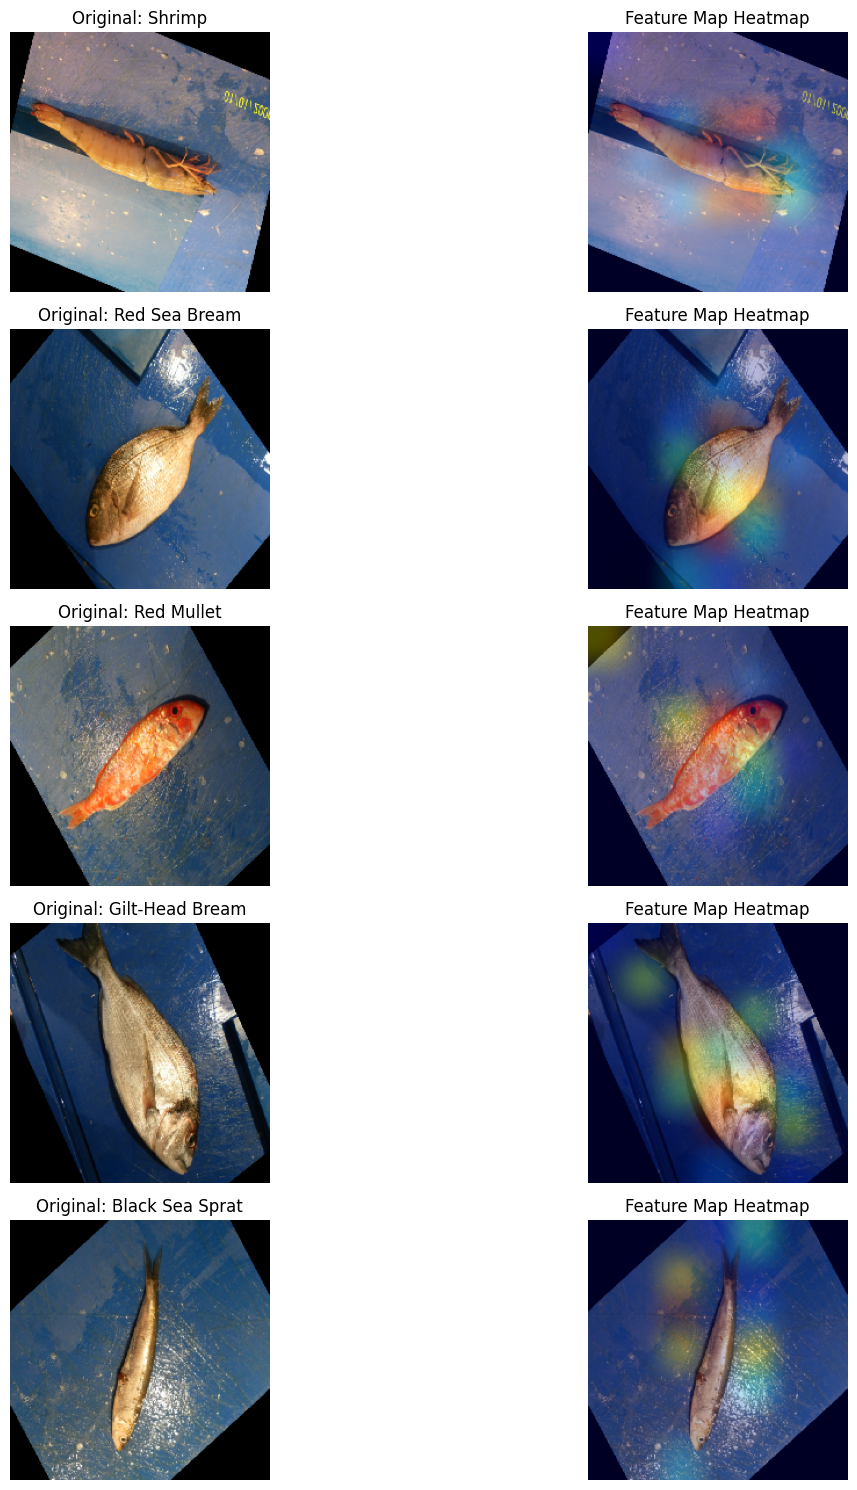

In [17]:
from tensorflow.keras.models import Model
import matplotlib.cm as cm

base_model = final_model.get_layer('densenet121')
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

layer_name = 'conv5_block16_concat'


feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# Function to normalize a tensor and convert it to an image
def normalize(tensor):
    tensor -= tensor.mean()
    tensor /= tensor.std() + 1e-5
    tensor *= 0.1
    tensor += 0.5
    tensor = np.clip(tensor, 0, 1)
    return tensor

def apply_heatmap(heatmap, img):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    return keras.preprocessing.image.array_to_img(superimposed_img)

# Visualize the feature maps for a sample of images from the test set
num_images_to_visualize = 5
sample_indices = random.sample(range(len(test_df)), num_images_to_visualize)
sample_images = test_df.iloc[sample_indices]['filepath'].values
sample_labels = test_df.iloc[sample_indices]['label'].values

plt.figure(figsize=(15, num_images_to_visualize * 3))
for i, img_path in enumerate(sample_images):
    img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Extract features
    features = feature_extractor.predict(img_array)
    features = features[0]

    # Average the features over all the channels
    heatmap = np.mean(features, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Apply the heatmap to the original image
    superimposed_img = apply_heatmap(heatmap, keras.preprocessing.image.img_to_array(img))

    plt.subplot(num_images_to_visualize, 2, 2 * i + 1)
    plt.imshow(img)
    plt.title(f"Original: {sample_labels[i]}")
    plt.axis('off')

    plt.subplot(num_images_to_visualize, 2, 2 * i + 2)
    plt.imshow(superimposed_img)
    plt.title("Feature Map Heatmap")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 9.5 MB/s eta 0:00:00


1/1 [==============================] - 0s 38ms/step


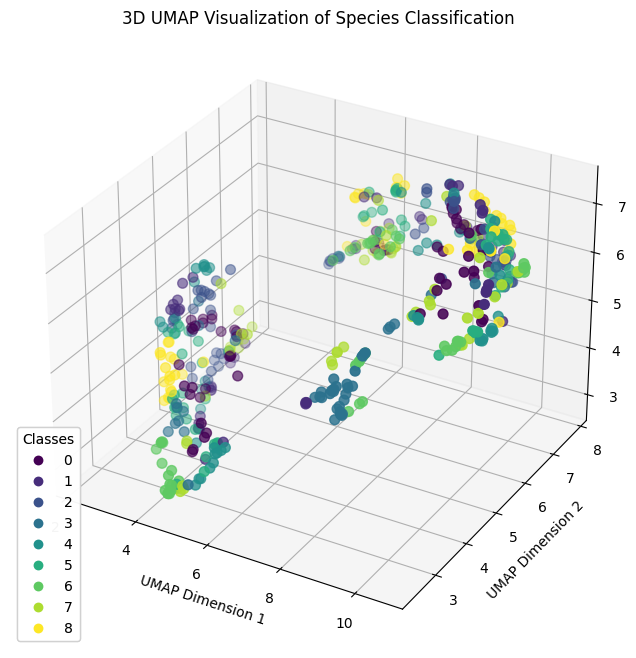

In [23]:
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to extract features from a set of images
def extract_features(image_paths, feature_extractor):
    features_list = []
    for img_path in image_paths:
        img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Extract features
        features = feature_extractor.predict(img_array)
        features = features.flatten()  # Flatten to use with UMAP
        features_list.append(features)

    return np.array(features_list)

# Extract features from a sample of images in the test set
num_images_to_visualize = 500
sample_indices = random.sample(range(len(test_df)), num_images_to_visualize)
sample_images = test_df.iloc[sample_indices]['filepath'].values
sample_labels = test_df.iloc[sample_indices]['label'].values

# Extract features using the feature extractor model
extracted_features = extract_features(sample_images, feature_extractor)

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(extracted_features)

# Apply UMAP for dimensionality reduction to 3D
reducer = umap.UMAP(n_components=3)
umap_embeddings = reducer.fit_transform(scaled_features)

# Convert species labels to numeric codes
label_to_code = {label: code for code, label in enumerate(np.unique(sample_labels))}
sample_labels_codes = np.array([label_to_code[label] for label in sample_labels])

# Plot 3D UMAP embeddings colored by species labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], umap_embeddings[:, 2], c=sample_labels_codes, cmap='viridis', s=50)
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend)

# Add labels for each axis
ax.set_title('3D UMAP Visualization of Species Classification')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')

plt.show()